In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from tabulate import tabulate
sns.set_theme()
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
df_law = pd.read_excel('./data/law.xlsx')
df_vio = pd.read_csv('./data/violence.csv')

In [4]:
ls = list(df_law['lawtotal'][df_law['lawtotal'].isna() == True].index)
df_law = df_law.drop(ls)

In [5]:
df_vio['date'] = pd.DatetimeIndex(df_vio['date'])
df_vio['year'] = df_vio['date'].dt.year

In [6]:
df_vio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   incident_id                  239677 non-null  int64         
 1   date                         239677 non-null  datetime64[ns]
 2   state                        239677 non-null  object        
 3   city_or_county               239677 non-null  object        
 4   address                      223180 non-null  object        
 5   n_killed                     239677 non-null  int64         
 6   n_injured                    239677 non-null  int64         
 7   incident_url                 239677 non-null  object        
 8   source_url                   239209 non-null  object        
 9   incident_url_fields_missing  239677 non-null  bool          
 10  congressional_district       227733 non-null  float64       
 11  gun_stolen                

In [7]:
df_law.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Columns: 137 entries, state to lawtotal
dtypes: int64(136), object(1)
memory usage: 1.6+ MB


In [8]:
def drop_nas(df, thresh=.4):
    cols = list(df.columns)
    ls = [['Column', '# of NAs', 'Percent']]
    drop = []
    l = len(df)
    for i in range(len(cols)):
        temp = df[cols[i]].isna().sum()
        if np.round(temp/l,2) >= 0.4:
            ls.append([cols[i], temp, np.round(temp/l,2)])
            drop.append(cols[i])
    for row in ls:
        print('| {:40} | {:10} | {:5} |'.format(*row))
    for i in range(len(drop)): #preventing memory issues by loading one frame at a time. 
        df = df.drop(drop[i], axis=1)
    return df

In [9]:
df_vio = drop_nas(df_vio)

| Column                                   | # of NAs   | Percent |
| gun_stolen                               |      99498 |  0.42 |
| gun_type                                 |      99451 |  0.41 |
| location_description                     |     197588 |  0.82 |
| n_guns_involved                          |      99451 |  0.41 |
| participant_name                         |     122253 |  0.51 |
| participant_relationship                 |     223903 |  0.93 |


In [10]:
df_vio = df_vio.drop(['incident_id', 'address', 'incident_url', 'source_url', 
             'incident_url_fields_missing', 'congressional_district', 
             'sources', 'state_house_district', 'state_senate_district', 'notes',
                     'participant_age','participant_status', ], axis=1)

In [11]:
df_vio.dtypes

date                        datetime64[ns]
state                               object
city_or_county                      object
n_killed                             int64
n_injured                            int64
incident_characteristics            object
latitude                           float64
longitude                          float64
participant_age_group               object
participant_gender                  object
participant_type                    object
year                                 int64
dtype: object

In [12]:
print('records before clean:',len(df_vio))
df_vio = df_vio.dropna()
print('records after clean:',len(df_vio))

records before clean: 239677
records after clean: 185573


In [13]:
df_vio['adult_count'] = df_vio.participant_age_group.str.count("Adult 18+")
df_vio['teen_count'] = df_vio.participant_age_group.str.count("Teen 12-17")
df_vio['child_count'] = df_vio.participant_age_group.str.count("Child 0-11")

In [14]:
df_vio['male_count'] = df_vio.participant_gender.str.count("Male")
df_vio['female_count'] = df_vio.participant_gender.str.count("Female")

In [15]:
df_vio['perpetator_count'] = df_vio.participant_type.str.count("Subject-Suspect")
df_vio['victim_count'] = df_vio.participant_type.str.count("Victim")

In [16]:
df_vio = df_vio.drop(['participant_age_group', 'participant_gender', 'participant_type'], axis=1)

In [17]:
df_vio.dtypes

date                        datetime64[ns]
state                               object
city_or_county                      object
n_killed                             int64
n_injured                            int64
incident_characteristics            object
latitude                           float64
longitude                          float64
year                                 int64
adult_count                          int64
teen_count                           int64
child_count                          int64
male_count                           int64
female_count                         int64
perpetator_count                     int64
victim_count                         int64
dtype: object

In [18]:
def agg_vio(df):
    vio_dict = {'state':[], 'year':[], 'n_incidents':[], 'total_killed':[], 'total_injured':[], 
               'total_adult':[], 'total_teen':[], 'total_child':[], 'total_male':[], 'total_female':[],
                'total_perp':[], 'total_victim':[]}
    states = list(df_vio.state.unique())
    years = list(df_vio.year.unique())
    for i in range(len(states)):
        df_state = df[df.state == states[i]]
        for j in range(len(years)):
            df_year = df_state[df_state.year == years[j]]
            vio_dict['state'].append(states[i])
            vio_dict['year'].append(years[j])
            
            vio_dict['n_incidents'].append(len(df_year))
            vio_dict['total_killed'].append(df_year.n_killed.sum())
            vio_dict['total_injured'].append(df_year.n_injured.sum())
            vio_dict['total_adult'].append(df_year.adult_count.sum())
            vio_dict['total_teen'].append(df_year.teen_count.sum())
            vio_dict['total_child'].append(df_year.child_count.sum())
            vio_dict['total_male'].append(df_year.male_count.sum())
            vio_dict['total_female'].append(df_year.female_count.sum())
            vio_dict['total_perp'].append(df_year.perpetator_count.sum())
            vio_dict['total_victim'].append(df_year.victim_count.sum())
    
    df_agg = pd.DataFrame.from_dict(vio_dict)
    return df_agg

In [19]:
df_agg = agg_vio(df_vio)

In [20]:
df_agg

,state,year,n_incidents,total_killed,total_injured,total_adult,total_teen,total_child,total_male,total_female,total_perp,total_victim
0,Pennsylvania,2013,18,12,50,69,6,0,62,8,15,61
1,Pennsylvania,2014,1982,524,1212,3005,172,39,2779,365,1348,2100
2,Pennsylvania,2015,1434,462,912,2140,162,35,2124,246,1131,1350
3,Pennsylvania,2016,1777,469,1044,2889,242,37,2851,346,1698,1592
4,Pennsylvania,2017,1845,603,1037,2728,244,35,2699,348,1562,1556
...,...,...,...,...,...,...,...,...,...,...,...,...
301,South Dakota,2014,49,13,16,63,14,3,74,16,52,49
302,South Dakota,2015,73,21,22,104,12,3,119,17,96,41
303,South Dakota,2016,97,17,26,120,12,0,114,25,106,38
304,South Dakota,2017,98,18,20,155,14,2,143,19,145,30


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'n_incidents'}>,
        <AxesSubplot:title={'center':'total_killed'}>],
       [<AxesSubplot:title={'center':'total_injured'}>,
        <AxesSubplot:title={'center':'total_adult'}>,
        <AxesSubplot:title={'center':'total_teen'}>],
       [<AxesSubplot:title={'center':'total_child'}>,
        <AxesSubplot:title={'center':'total_male'}>,
        <AxesSubplot:title={'center':'total_female'}>],
       [<AxesSubplot:title={'center':'total_perp'}>,
        <AxesSubplot:title={'center':'total_victim'}>, <AxesSubplot:>]],
      dtype=object)

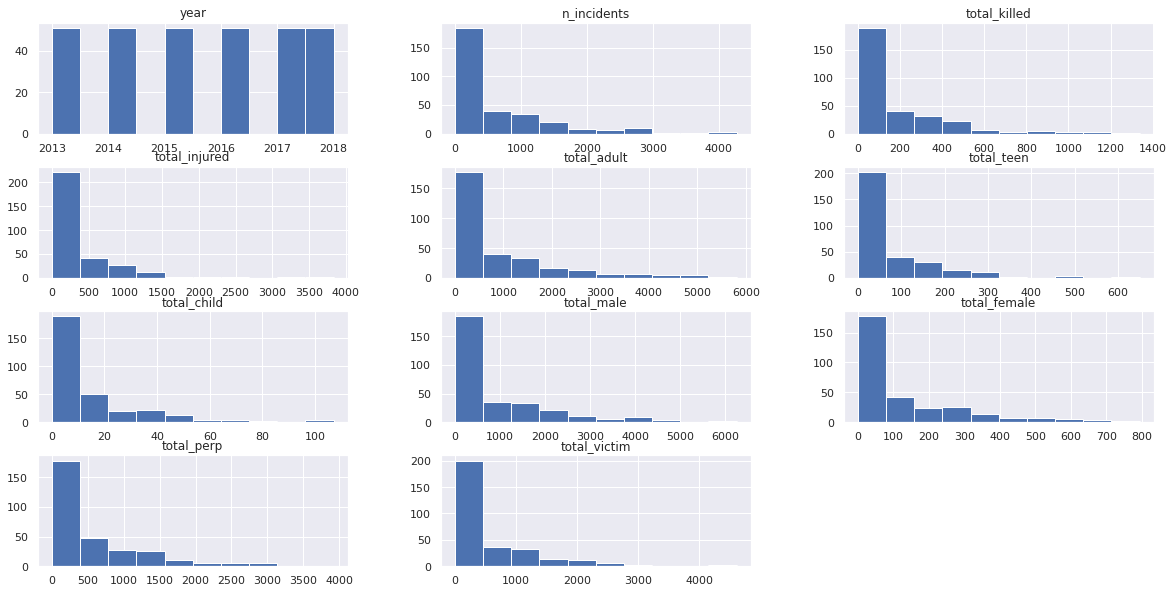

In [21]:
df_agg.hist(figsize=(20,10))

Text(0.5, 1.0, 'Number of Gun Violence Incidents by State (across all years)')

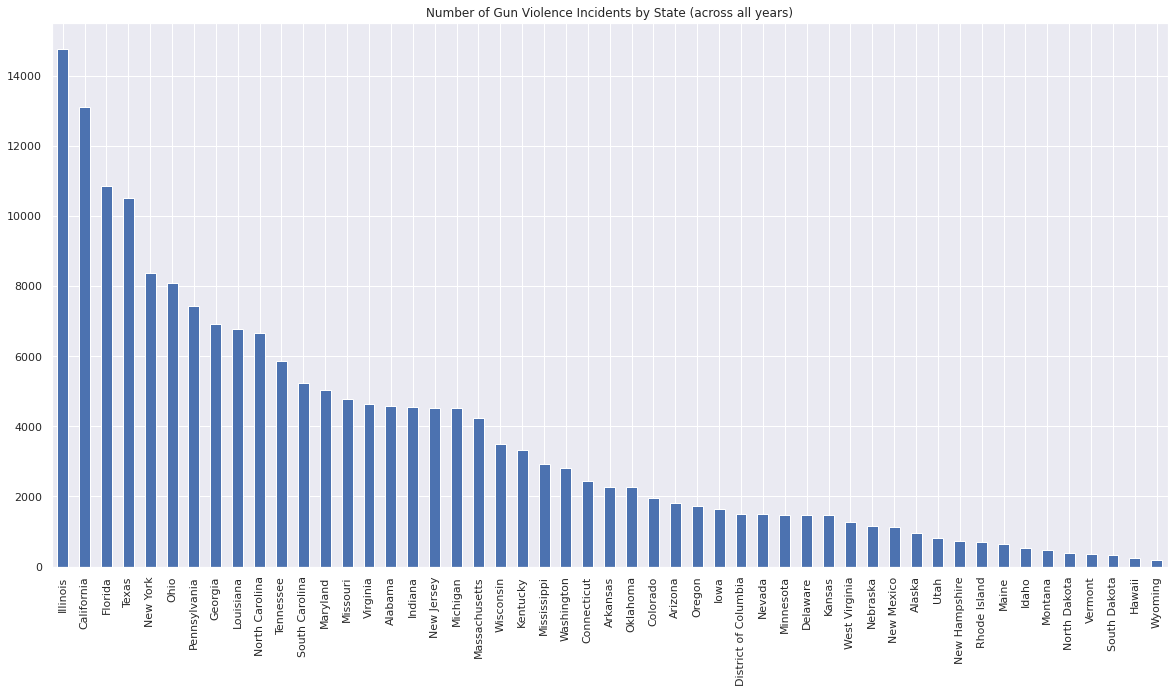

In [22]:
df_vio.state.value_counts().plot(kind='bar', figsize=(20,10))
plt.title('Number of Gun Violence Incidents by State (across all years)')

In [23]:
print(list(df_law.columns))

['state', 'year', 'felony', 'invcommitment', 'invoutpatient', 'danger', 'drugmisdemeanor', 'alctreatment', 'alcoholism', 'relinquishment', 'violent', 'violenth', 'violentpartial', 'dealer', 'dealerh', 'recordsall', 'recordsallh', 'recordsdealer', 'recordsdealerh', 'reportall', 'reportallh', 'reportdealer', 'reportdealerh', 'purge', 'residential', 'theft', 'security', 'inspection', 'ammlicense', 'ammrecords', 'permit', 'permith', 'fingerprint', 'training', 'permitlaw', 'registration', 'registrationh', 'defactoreg', 'defactoregh', 'ammpermit', 'ammrestrict', 'age21handgunsale', 'age18longgunsale', 'age21longgunsaled', 'age21longgunsale', 'age21handgunpossess', 'age18longgunpossess', 'age21longgunpossess', 'loststolen', 'amm18', 'amm21h', 'universal', 'universalh', 'gunshow', 'gunshowh', 'universalpermit', 'universalpermith', 'backgroundpurge', 'ammbackground', 'threedaylimit', 'mentalhealth', 'statechecks', 'statechecksh', 'waiting', 'waitingh', 'assault', 'onefeature', 'assaultlist', 'a

In [24]:
df_law.lawtotal

0       15
1       16
2       16
3       16
4       16
        ..
1495     8
1496     8
1497     7
1498     7
1499     7
Name: lawtotal, Length: 1500, dtype: int64

In [25]:
df_law.state

0       Alabama
1       Alabama
2       Alabama
3       Alabama
4       Alabama
         ...   
1495    Wyoming
1496    Wyoming
1497    Wyoming
1498    Wyoming
1499    Wyoming
Name: state, Length: 1500, dtype: object

In [26]:
df_merge = pd.merge(df_law, df_agg,  how='left', left_on=['state','year'], right_on = ['state','year'])
print('records before clean:',len(df_merge))
df_merge = df_merge.dropna()
print('records after clean:',len(df_merge))

records before clean: 1500
records after clean: 300


In [27]:
df_merge

,state,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,violent,violenth,violentpartial,dealer,dealerh,recordsall,recordsallh,recordsdealer,recordsdealerh,reportall,reportallh,reportdealer,reportdealerh,purge,residential,theft,security,inspection,ammlicense,ammrecords,permit,permith,fingerprint,training,permitlaw,registration,registrationh,defactoreg,defactoregh,ammpermit,ammrestrict,age21handgunsale,age18longgunsale,age21longgunsaled,age21longgunsale,age21handgunpossess,age18longgunpossess,age21longgunpossess,loststolen,amm18,amm21h,universal,universalh,gunshow,gunshowh,universalpermit,universalpermith,backgroundpurge,ammbackground,threedaylimit,mentalhealth,statechecks,statechecksh,waiting,waitingh,assault,onefeature,assaultlist,assaultregister,assaulttransfer,magazine,tenroundlimit,magazinepreowned,onepermonth,traffickingbackground,traffickingprohibited,traffickingprohibitedh,strawpurchase,strawpurchaseh,microstamp,gvro,gvrolawenforcement,college,collegeconcealed,elementary,opencarryh,opencarryl,opencarrypermith,opencarrypermitl,permitconcealed,mayissue,showing,ccbackground,ccbackgroundnics,ccrenewbackground,ccrevoke,nosyg,personalized,lockd,lockp,locked,lockstandards,capliability,capaccess,capuses,capunloaded,cap18,cap16,cap14,junkgun,liability,immunity,preemption,preemptionnarrow,preemptionbroad,mcdv,mcdvdating,mcdvsurrender,mcdvsurrendernoconditions,mcdvsurrenderdating,mcdvremovalallowed,mcdvremovalrequired,incidentremoval,incidentall,dvro,dvrodating,exparte,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal,n_incidents,total_killed,total_injured,total_adult,total_teen,total_child,total_male,total_female,total_perp,total_victim
22,Alabama,2013,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2.0,3.0,9.0,10.0,0.0,0.0,8.0,2.0,3.0,12.0
23,Alabama,2014,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1147.0,320.0,542.0,2091.0,124.0,33.0,1893.0,306.0,1214.0,1200.0
24,Alabama,2015,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,884.0,377.0,495.0,1475.0,96.0,19.0,1291.0,238.0,727.0,901.0
25,Alabama,2016,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,1044.0,436.0,607.0,1672.0,92.0,25.0,1508.0,241.0,850.0,1028.0
26,Alabama,2017,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,1233.0,536.0,728.0,1902.0,131.0,30.0,1747.0,322.0,1000.0,1204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [28]:
df_merge.to_csv('./data/merged.csv', index = False)

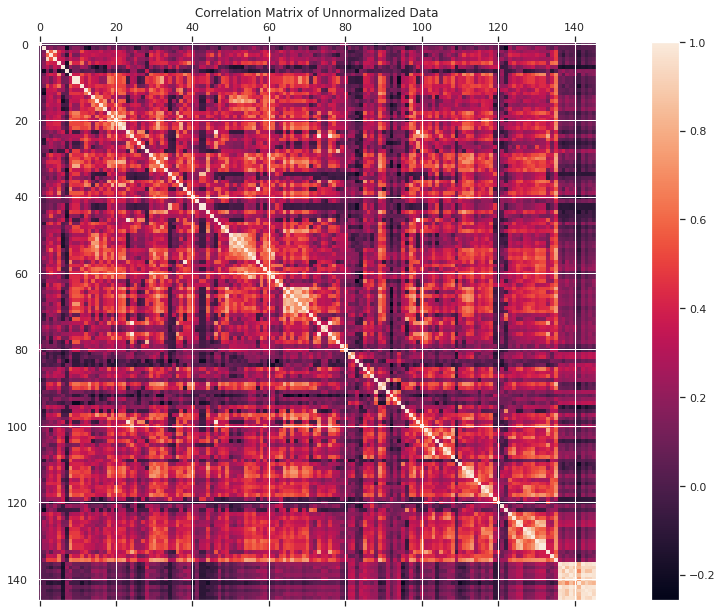

In [363]:
ax = plt.figure(figsize=(20,10))
ax = plt.matshow(df_merge.corr(), fignum=1)
cb = plt.colorbar()
ax = plt.title('Correlation Matrix of Unnormalized Data')
plt.show()

In [30]:
df_corr = df_merge.corr()

In [31]:
df_corr[df_corr.total_victim > .3]

,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,violent,violenth,violentpartial,dealer,dealerh,recordsall,recordsallh,recordsdealer,recordsdealerh,reportall,reportallh,reportdealer,reportdealerh,purge,residential,theft,security,inspection,ammlicense,ammrecords,permit,permith,fingerprint,training,permitlaw,registration,registrationh,defactoreg,defactoregh,ammpermit,ammrestrict,age21handgunsale,age18longgunsale,age21longgunsaled,age21longgunsale,age21handgunpossess,age18longgunpossess,age21longgunpossess,loststolen,amm18,amm21h,universal,universalh,gunshow,gunshowh,universalpermit,universalpermith,backgroundpurge,ammbackground,threedaylimit,mentalhealth,statechecks,statechecksh,waiting,waitingh,assault,onefeature,assaultlist,assaultregister,assaulttransfer,magazine,tenroundlimit,magazinepreowned,onepermonth,traffickingbackground,traffickingprohibited,traffickingprohibitedh,strawpurchase,strawpurchaseh,microstamp,gvro,gvrolawenforcement,college,collegeconcealed,elementary,opencarryh,opencarryl,opencarrypermith,opencarrypermitl,permitconcealed,mayissue,showing,ccbackground,ccbackgroundnics,ccrenewbackground,ccrevoke,nosyg,personalized,lockd,lockp,locked,lockstandards,capliability,capaccess,capuses,capunloaded,cap18,cap16,cap14,junkgun,liability,immunity,preemption,preemptionnarrow,preemptionbroad,mcdv,mcdvdating,mcdvsurrender,mcdvsurrendernoconditions,mcdvsurrenderdating,mcdvremovalallowed,mcdvremovalrequired,incidentremoval,incidentall,dvro,dvrodating,exparte,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal,n_incidents,total_killed,total_injured,total_adult,total_teen,total_child,total_male,total_female,total_perp,total_victim
college,-1.014534e-02,0.163376,-0.070369,0.003147,-0.047288,-0.053936,-0.156885,-0.030421,0.117119,-0.069486,-0.069486,0.016640,0.054728,-0.090487,0.079727,0.108037,0.110773,0.262730,0.138819,0.022790,0.174569,0.146521,0.127915,0.189106,0.270208,-0.003099,0.058003,0.077496,0.189106,0.161362,0.222508,0.295489,-0.023034,0.166374,-0.107919,-0.015759,0.144584,0.086196,0.159339,0.201102,0.088177,0.057029,-0.082022,-0.082022,0.010587,-0.132418,0.189106,0.145674,-0.065114,0.124015,0.086206,0.014407,0.171704,0.097660,0.224592,0.184238,0.231394,0.159339,0.075789,0.195229,0.253932,0.200886,0.098214,0.008672,0.232895,0.159339,0.232895,0.237071,0.083792,0.284347,0.176152,0.292876,0.159339,0.270208,0.133644,0.158693,0.270208,0.083792,0.133070,0.052766,-0.077317,1.000000,0.777851,0.206647,0.363171,0.302636,0.193902,0.295489,0.140651,0.079013,0.054728,0.204452,-0.027737,0.126487,0.443267,0.120428,0.058003,0.142077,0.237071,0.189106,0.334438,0.083792,0.174569,0.105784,-0.015759,0.164024,0.121031,0.105784,0.104931,-0.154202,0.247840,0.164024,0.294411,0.350872,0.078821,0.040845,0.198986,0.184186,0.159395,-0.139525,-0.098349,0.062314,0.189106,0.192166,0.185987,0.270121,0.322329,0.162065,0.236478,0.137285,0.264940,0.326227,0.326227,0.201937,0.053708,0.257247,0.316602,0.290883,0.296547,0.325186,0.309556,0.222052,0.325518,0.296587,0.335395,0.304348
collegeconcealed,-3.351352e-02,0.035144,-0.063340,0.051647,-0.054311,0.060163,-0.081152,0.011682,0.220557,-0.060760,-0.060760,0.054968,0.114805,0.020040,0.030654,0.048466,0.051367,0.218575,0.073804,0.026650,0.048825,0.106338,0.114715,0.243113,0.269490,0.064844,0.113715,0.137305,0.134094,0.272076,0.353561,0.221281,0.017848,0.319174,-0.083945,0.044345,0.186049,0.168013,0.237148,0.314284,0.218149,0.092456,-0.049895,-0.049895,0.118236,-0.008577,0.243113,0.269615,-0.017155,0.201501,-0.048294,-0.088295,0.031859,-0.012875,0.170109,0.195236,0.181518,0.237148,0.162820,0.168013,0.131644,0.157765,0.126552,0.079436,0.299655,0.172880,0.299655,0.276795,0.108018,0.238762,0.226723,0.376520,0.172880,0.269490,0.149029,0.196266,0.269490,0.108018,0.092210,0.060936,-0.039116,0.777851,1.000000,0.344365,0.466890,0.363762,0.278913,0

In [32]:
print(list(df_law.columns))

['state', 'year', 'felony', 'invcommitment', 'invoutpatient', 'danger', 'drugmisdemeanor', 'alctreatment', 'alcoholism', 'relinquishment', 'violent', 'violenth', 'violentpartial', 'dealer', 'dealerh', 'recordsall', 'recordsallh', 'recordsdealer', 'recordsdealerh', 'reportall', 'reportallh', 'reportdealer', 'reportdealerh', 'purge', 'residential', 'theft', 'security', 'inspection', 'ammlicense', 'ammrecords', 'permit', 'permith', 'fingerprint', 'training', 'permitlaw', 'registration', 'registrationh', 'defactoreg', 'defactoregh', 'ammpermit', 'ammrestrict', 'age21handgunsale', 'age18longgunsale', 'age21longgunsaled', 'age21longgunsale', 'age21handgunpossess', 'age18longgunpossess', 'age21longgunpossess', 'loststolen', 'amm18', 'amm21h', 'universal', 'universalh', 'gunshow', 'gunshowh', 'universalpermit', 'universalpermith', 'backgroundpurge', 'ammbackground', 'threedaylimit', 'mentalhealth', 'statechecks', 'statechecksh', 'waiting', 'waitingh', 'assault', 'onefeature', 'assaultlist', 'a

In [33]:
df_agg.year.value_counts()

2013    51
2014    51
2015    51
2016    51
2017    51
2018    51
Name: year, dtype: int64

In [34]:
df_agg.columns

Index(['state', 'year', 'n_incidents', 'total_killed', 'total_injured',
       'total_adult', 'total_teen', 'total_child', 'total_male',
       'total_female', 'total_perp', 'total_victim'],
      dtype='object')

array([[<AxesSubplot:title={'center':'n_incidents'}>,
        <AxesSubplot:title={'center':'total_killed'}>,
        <AxesSubplot:title={'center':'total_injured'}>],
       [<AxesSubplot:title={'center':'total_adult'}>,
        <AxesSubplot:title={'center':'total_teen'}>,
        <AxesSubplot:title={'center':'total_child'}>],
       [<AxesSubplot:title={'center':'total_male'}>,
        <AxesSubplot:title={'center':'total_female'}>,
        <AxesSubplot:title={'center':'total_perp'}>],
       [<AxesSubplot:title={'center':'total_victim'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

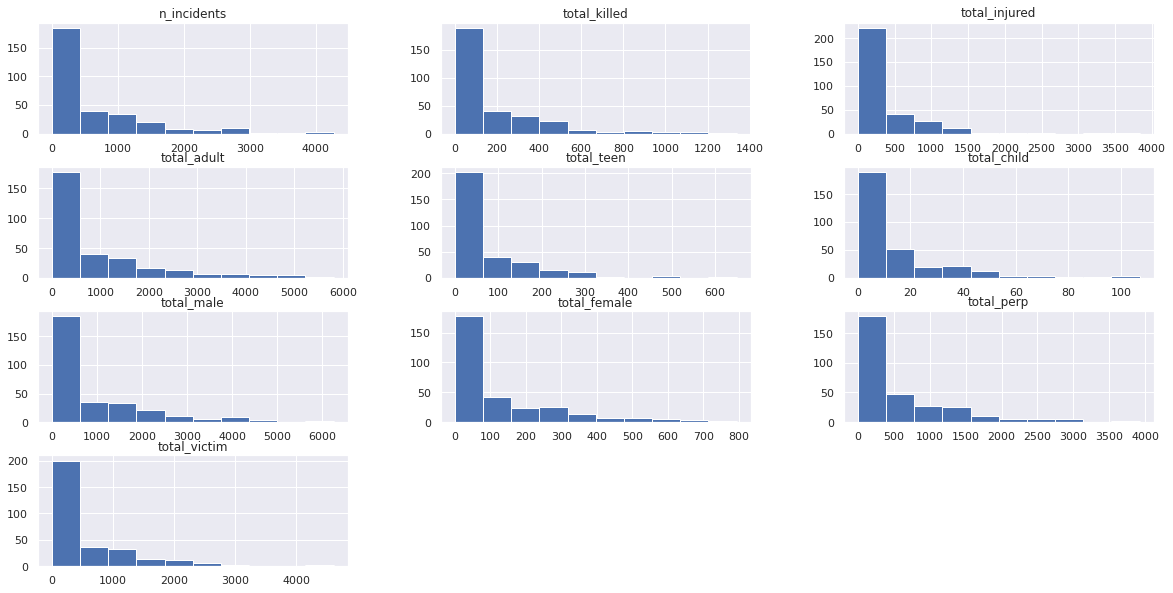

In [35]:
df_agg.hist(['n_incidents', 'total_killed', 'total_injured',
       'total_adult', 'total_teen', 'total_child', 'total_male',
       'total_female', 'total_perp', 'total_victim'], figsize=(20,10))

Text(0.5, 1.0, 'Gun Violence Target Variables by Year')

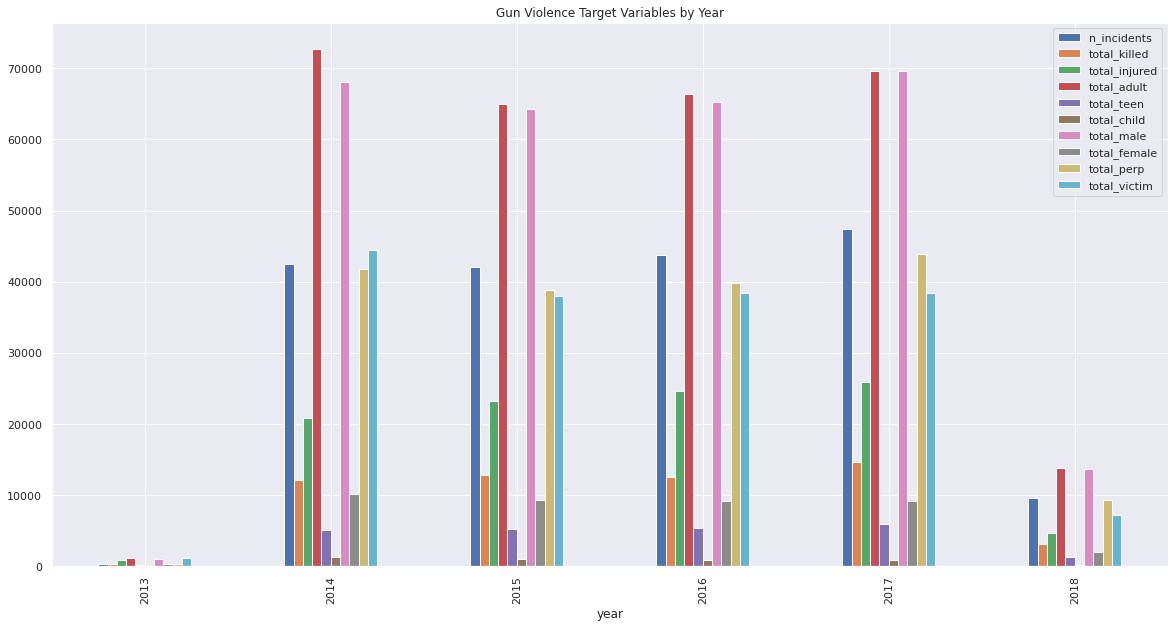

In [36]:
df_agg.groupby('year').sum().plot(kind='bar',figsize=(20,10))
plt.title('Gun Violence Target Variables by Year')

In [37]:
df_pop = pd.read_excel('./data/censusData.xlsx')

In [38]:
df_pop = df_pop.dropna()
df_pop.columns = ['state', 'census', 'estimates', 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [39]:
df_pop

,state,census,estimates,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
3,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,Northeast,55317240,55318443,55380134,55604223.0,55775216.0,55901806.0,56006011.0,56034684.0,56042330.0,56059240.0,56046620.0,55982803.0
5,Midwest,66927001,66929725,66974416,67157800.0,67336743.0,67560379.0,67745167.0,67860583.0,67987540.0,68126781.0,68236628.0,68329004.0
6,South,114555744,114563030,114866680,116006522.0,117241208.0,118364400.0,119624037.0,120997341.0,122351760.0,123542189.0,124569433.0,125580448.0
7,West,71945553,71946907,72100436,72788329.0,73477823.0,74167130.0,74925793.0,75742555.0,76559681.0,77257329.0,77834820.0,78347268.0
8,.Alabama,4779736,4780125,4785437,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0
9,.Alaska,710231,710249,713910,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0
10,.Arizona,6392017,6392288,6407172,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0
11,.Arkansas,2915918,2916031,2921964,2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0
12,.California,37253956,37254519,37319502,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0


In [40]:
def pop_data(df):
    vio_dict = {'state':[], 'year':[], 'pop':[]}
    states = list(df.state.unique())
    years = range(2013, 2019)
    for i in range(len(states)):
        df_state = df[df.state == states[i]]
        for j in range(len(years)):
            pop = df_state[years[j]]
#             print(pop)
            vio_dict['state'].append(states[i])
            vio_dict['year'].append(years[j])
            vio_dict['pop'].append(list(pop)[0])
    
    df_agg = pd.DataFrame.from_dict(vio_dict)
    return df_agg

In [41]:
df_pop_clean = pop_data(df_pop)
df_pop_clean['state'] = df_pop_clean['state'].str.replace(r'[^\w\s]+', '')

/tmp/ipykernel_123/629628399.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pop_clean['state'] = df_pop_clean['state'].str.replace(r'[^\w\s]+', '')


In [42]:
df_merge_pop = pd.merge(df_merge, df_pop_clean,  how='left', left_on=['state','year'], right_on = ['state','year'])

In [43]:
df_agg.columns

Index(['state', 'year', 'n_incidents', 'total_killed', 'total_injured',
       'total_adult', 'total_teen', 'total_child', 'total_male',
       'total_female', 'total_perp', 'total_victim'],
      dtype='object')

In [44]:
df_merge_pop['norm_n_incidents'] = df_merge_pop['n_incidents']/df_merge_pop['pop']
df_merge_pop['norm_tot_killed'] = df_merge_pop['total_killed']/df_merge_pop['pop']
df_merge_pop['norm_tot_injured'] = df_merge_pop['total_injured']/df_merge_pop['pop']
df_merge_pop['norm_tot_adult'] = df_merge_pop['total_adult']/df_merge_pop['pop']
df_merge_pop['norm_tot_teen'] = df_merge_pop['total_teen']/df_merge_pop['pop']
df_merge_pop['norm_tot_child'] = df_merge_pop['total_child']/df_merge_pop['pop']
df_merge_pop['norm_tot_male'] = df_merge_pop['total_male']/df_merge_pop['pop']
df_merge_pop['norm_tot_female'] = df_merge_pop['total_female']/df_merge_pop['pop']
df_merge_pop['norm_tot_perp'] = df_merge_pop['total_perp']/df_merge_pop['pop']
df_merge_pop['norm_tot_victim'] = df_merge_pop['total_victim']/df_merge_pop['pop']

In [45]:
df_pop_corr = df_merge_pop.corr()

In [46]:
df_pop_corr[df_pop_corr.norm_n_incidents < -.1]

,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,violent,violenth,violentpartial,dealer,dealerh,recordsall,recordsallh,recordsdealer,recordsdealerh,reportall,reportallh,reportdealer,reportdealerh,purge,residential,theft,security,inspection,ammlicense,ammrecords,permit,permith,fingerprint,training,permitlaw,registration,registrationh,defactoreg,defactoregh,ammpermit,ammrestrict,age21handgunsale,age18longgunsale,age21longgunsaled,age21longgunsale,age21handgunpossess,age18longgunpossess,age21longgunpossess,loststolen,amm18,amm21h,universal,universalh,gunshow,gunshowh,universalpermit,universalpermith,backgroundpurge,ammbackground,threedaylimit,mentalhealth,statechecks,statechecksh,waiting,waitingh,assault,onefeature,assaultlist,assaultregister,assaulttransfer,magazine,tenroundlimit,magazinepreowned,onepermonth,traffickingbackground,traffickingprohibited,traffickingprohibitedh,strawpurchase,strawpurchaseh,microstamp,gvro,gvrolawenforcement,college,collegeconcealed,elementary,opencarryh,opencarryl,opencarrypermith,opencarrypermitl,permitconcealed,mayissue,showing,ccbackground,ccbackgroundnics,ccrenewbackground,ccrevoke,nosyg,personalized,lockd,lockp,locked,lockstandards,capliability,capaccess,capuses,capunloaded,cap18,cap16,cap14,junkgun,liability,immunity,preemption,preemptionnarrow,preemptionbroad,mcdv,mcdvdating,mcdvsurrender,mcdvsurrendernoconditions,mcdvsurrenderdating,mcdvremovalallowed,mcdvremovalrequired,incidentremoval,incidentall,dvro,dvrodating,exparte,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal,n_incidents,total_killed,total_injured,total_adult,total_teen,total_child,total_male,total_female,total_perp,total_victim,pop,norm_n_incidents,norm_tot_killed,norm_tot_injured,norm_tot_adult,norm_tot_teen,norm_tot_child,norm_tot_male,norm_tot_female,norm_tot_perp,norm_tot_victim
alctreatment,-1.483945e-02,0.199217,0.332472,0.165048,0.355581,0.278431,1.000000,-0.109855,0.229267,0.113594,0.113594,0.264256,0.228462,0.056616,-0.102119,-0.193141,-0.030750,-0.154423,0.297835,0.128428,0.199247,0.067571,0.108988,0.380872,0.233827,0.185875,0.285558,0.218904,-0.053583,0.246873,0.081307,0.140903,0.267032,0.101205,0.380872,0.161352,0.434216,0.145216,0.161352,0.094460,0.053652,0.084242,0.315452,0.315452,0.195774,0.240209,0.380872,0.022668,0.053172,0.002212,-0.136046,-0.164304,-0.153672,-0.180906,0.097793,-0.006758,0.019909,0.161352,0.154268,-0.014265,0.145968,0.027967,0.143656,0.235058,0.048665,-0.094762,0.048665,-0.110605,-0.110605,0.020154,0.072490,-0.082986,-0.094762,0.233827,0.154457,0.117734,0.233827,0.113594,-0.062084,-0.013177,-0.076413,-0.156885,-0.081152,-0.033536,-0.102904,0.280465,0.228481,0.299220,-0.002212,0.167289,0.053172,0.010137,0.146235,0.088252,-0.056065,0.241063,-0.076563,-0.010137,0.113594,0.380872,0.161352,0.337793,0.374538,0.285988,0.417465,0.280465,0.216781,0.285988,0.423008,-0.076563,0.265786,0.280465,0.199247,0.168122,-0.002367,0.152502,0.220457,0.273488,0.346811,0.360299,0.347097,-0.068360,-0.053583,0.114013,0.245890,0.128428,0.154097,0.249289,0.293122,0.353829,0.183116,0.216730,0.216730,0.360299,0.212224,0.237647,-0.149043,-0.186959,-0.151231,-0.153998,-0.138301,-0.173831,-0.150652,-0.165650,-0.137298,-0.164878,-0.138254,-0.134299,-0.200590,-0.146763,-0.140319,-0.126750,-0.155248,-0.138710,-0.147020,-0.114375,-0.160500
dealer,-5.814718e-15,-0.155059,0.357641,0.352694,0.382499,0.240338,0.228462,0.053172,0.403753,0.305943,0.305943,0.341033,1.000000,0.641689,0.219404,0.410428,0.337224,0.386427,0.464971,0.661655,0.501661,0.571393,0.505813,0.354068,0.505917,0.592870,0.505917,0.527492,0.354068,0.643855,0.532676,0.411078,0.560495,0.430787,0.354068,0.140768,0.607458,0.694696,0.140768,0.342289,0.381537,0.373242,0.290985,0.290985,0.452803,0.448066,0.354068,0.335101,0.335548,0.295580,0.269376,0.369005,0.225836,0.327345,0.560533,0.517951,0.343795,0

<Figure size 1440x720 with 0 Axes>

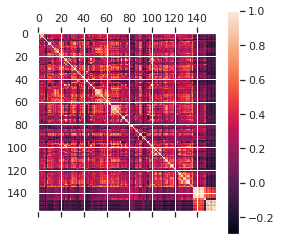

In [47]:
ax = plt.figure(figsize=(20,10))
ax = plt.matshow(df_merge_pop.corr())
cb = plt.colorbar()
plt.show()

In [209]:
df_pop_corr

,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,violent,violenth,violentpartial,dealer,dealerh,recordsall,recordsallh,recordsdealer,recordsdealerh,reportall,reportallh,reportdealer,reportdealerh,purge,residential,theft,security,inspection,ammlicense,ammrecords,permit,permith,fingerprint,training,permitlaw,registration,registrationh,defactoreg,defactoregh,ammpermit,ammrestrict,age21handgunsale,age18longgunsale,age21longgunsaled,age21longgunsale,age21handgunpossess,age18longgunpossess,age21longgunpossess,loststolen,amm18,amm21h,universal,universalh,gunshow,gunshowh,universalpermit,universalpermith,backgroundpurge,ammbackground,threedaylimit,mentalhealth,statechecks,statechecksh,waiting,waitingh,assault,onefeature,assaultlist,assaultregister,assaulttransfer,magazine,tenroundlimit,magazinepreowned,onepermonth,traffickingbackground,traffickingprohibited,traffickingprohibitedh,strawpurchase,strawpurchaseh,microstamp,gvro,gvrolawenforcement,college,collegeconcealed,elementary,opencarryh,opencarryl,opencarrypermith,opencarrypermitl,permitconcealed,mayissue,showing,ccbackground,ccbackgroundnics,ccrenewbackground,ccrevoke,nosyg,personalized,lockd,lockp,locked,lockstandards,capliability,capaccess,capuses,capunloaded,cap18,cap16,cap14,junkgun,liability,immunity,preemption,preemptionnarrow,preemptionbroad,mcdv,mcdvdating,mcdvsurrender,mcdvsurrendernoconditions,mcdvsurrenderdating,mcdvremovalallowed,mcdvremovalrequired,incidentremoval,incidentall,dvro,dvrodating,exparte,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal,n_incidents,total_killed,total_injured,total_adult,total_teen,total_child,total_male,total_female,total_perp,total_victim,pop,norm_n_incidents,norm_tot_killed,norm_tot_injured,norm_tot_adult,norm_tot_teen,norm_tot_child,norm_tot_male,norm_tot_female,norm_tot_perp,norm_tot_victim
year,1.000000e+00,2.729105e-14,0.035388,0.027431,0.031273,0.019769,-0.014839,-0.014839,0.014839,1.107736e-14,1.107736e-14,-2.601661e-14,-5.814718e-15,-0.010828,0.024628,0.029299,0.011716,-0.026011,0.026838,0.032339,-9.386233e-15,-0.018111,-0.019281,-2.261282e-14,-4.309889e-16,-0.020949,-2.738286e-14,0.023965,2.200308e-14,0.037724,0.011171,-1.492593e-14,-7.250751e-15,0.011480,4.560815e-15,-1.646254e-14,0.021105,0.012794,-1.287184e-14,-3.023533e-16,0.021581,0.009947,0.060575,0.060575,-2.975229e-14,1.057329e-14,-2.261282e-14,0.020949,-8.484143e-15,-9.112083e-15,0.069212,0.075167,0.045083,0.053336,0.059411,0.052861,0.021296,-1.287184e-14,0.047265,0.012794,0.012276,0.010490,0.017655,-0.007794,-1.044285e-14,1.926693e-14,-1.044285e-14,9.720494e-15,6.316853e-15,0.013925,0.016030,0.037014,-7.253242e-15,-4.309889e-16,0.017951,0.027959,-4.309889e-16,-2.185479e-14,-0.048460,0.206591,0.187140,-0.010145,-0.033514,-0.048532,-0.034424,9.478528e-15,-1.178766e-14,-9.782259e-15,-0.175691,-3.082989e-15,-4.886711e-16,-0.121988,0.009947,-0.070502,-0.100198,-0.052728,-2.451384e-14,-3.626417e-14,4.668649e-16,-2.261282e-14,-3.103677e-15,-2.785654e-14,-2.579028e-14,-1.448691e-14,-2.269544e-14,1.655537e-15,-3.906697e-15,-1.448691e-14,-2.756199e-14,-4.251558e-15,-4.383922e-14,-9.901080e-15,-9.611053e-15,-1.466646e-14,0.130843,0.123096,0.071177,0.076112,0.070421,0.052088,0.038115,-1.430304e-14,-1.385928e-14,0.126870,0.065035,0.022389,0.023382,0.054702,0.056933,0.079251,0.024598,0.026117,0.026117,0.052088,0.046561,0.025078,0.079575,0.085456,0.070567,0.046857,0.078238,-0.050652,0.057477,0.032234,0.074784,0.015963,0.010303,0.118060,0.138738,0.107365,0.067991,0.091535,-0.089001,0.079432,0.033119,0.100373,0.008397
felony,2.729105e-14,1.000000e+00,0.132885,0.200133,0.107760,0.174728,0.199217,-0.216781,0.083662,1.747921e-01,1.747921e-01,1.133851e-01,-1.550587e-01,-0.234414,0.068083,0.026325,0.098897,0.068865,0.190180,0.054627,1.077527e-01,0.092376,0.152394,8.467843e-02,1.209944e-01,-0.142738,-1.116871e-01,0.1261

Text(0.5, 1.0, 'Correlation Between Features and Select Target Variables (normalized by population)')

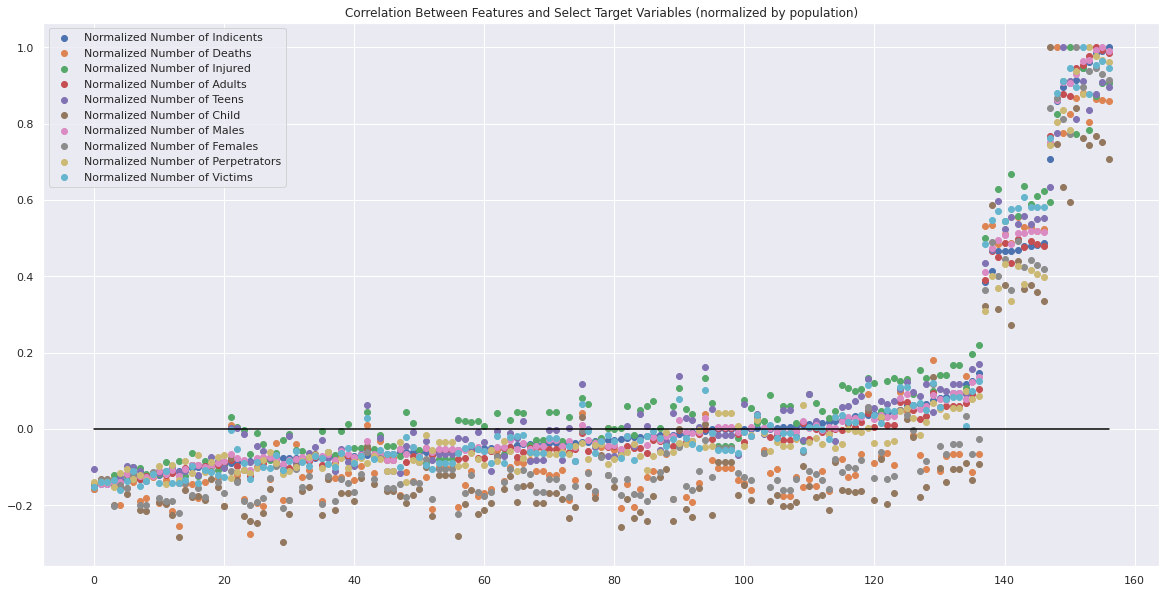

In [274]:
df_pop_corr = df_pop_corr.sort_values(['norm_n_incidents'])
plt.figure(figsize=(20,10))
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_n_incidents, label="Normalized Number of Indicents")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_killed, label="Normalized Number of Deaths")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_injured, label="Normalized Number of Injured")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_adult, label="Normalized Number of Adults")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_teen, label="Normalized Number of Teens")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_child, label="Normalized Number of Child")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_male, label="Normalized Number of Males")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_female, label="Normalized Number of Females")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_perp, label="Normalized Number of Perpetrators")
plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_victim, label="Normalized Number of Victims")
# plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_child, label="Normalized Number of Child")
plt.plot(range(len(df_pop_corr)), np.zeros(len(df_pop_corr)), color ='black')
plt.legend()
plt.title('Correlation Between Features and Select Target Variables (normalized by population)')
# plt.plot(range(len(df_pop_corr)), df_pop_corr.lawtotal)

Text(0.5, 1.0, 'Correlation Between Features and Select Target Variables (normalized by population)')

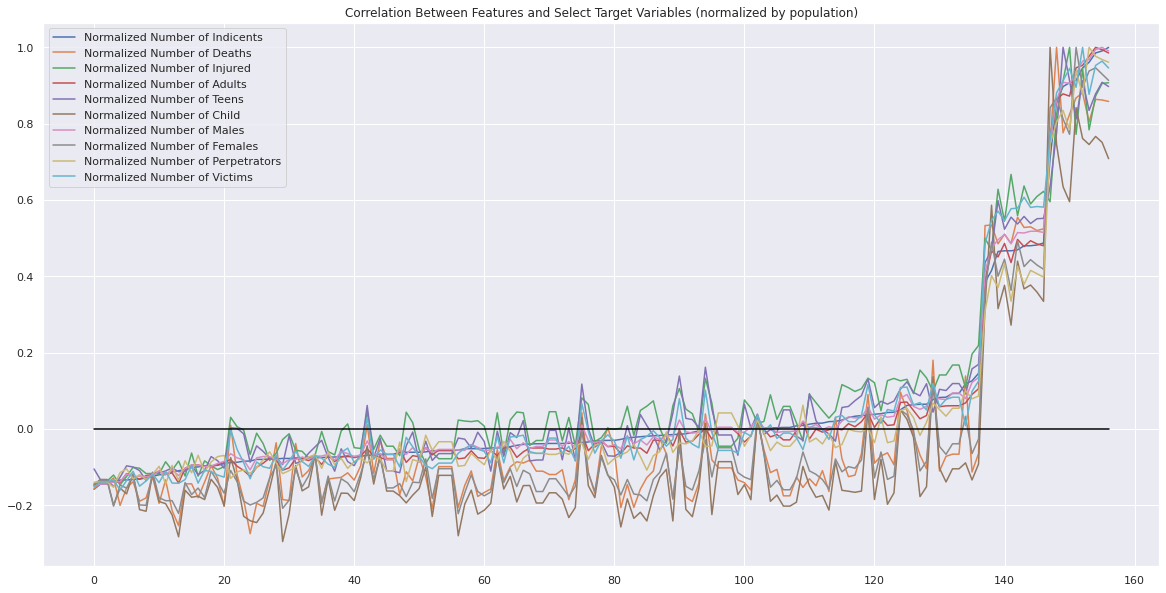

In [273]:
df_pop_corr = df_pop_corr.sort_values(['norm_n_incidents'])
plt.figure(figsize=(20,10))
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_n_incidents, label="Normalized Number of Indicents")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_killed, label="Normalized Number of Deaths")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_injured, label="Normalized Number of Injured")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_adult, label="Normalized Number of Adults")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_teen, label="Normalized Number of Teens")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_child, label="Normalized Number of Child")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_male, label="Normalized Number of Males")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_female, label="Normalized Number of Females")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_perp, label="Normalized Number of Perpetrators")
plt.plot(range(len(df_pop_corr)), df_pop_corr.norm_tot_victim, label="Normalized Number of Victims")
# plt.scatter(range(len(df_pop_corr)), df_pop_corr.norm_tot_child, label="Normalized Number of Child")
plt.plot(range(len(df_pop_corr)), np.zeros(len(df_pop_corr)), color ='black')
plt.legend()
plt.title('Correlation Between Features and Select Target Variables (normalized by population)')
# plt.plot(range(len(df_pop_corr)), df_pop_corr.lawtotal)

In [280]:
def small_large(feature):
    a = df_pop_corr.nsmallest(10, feature)[feature]
    b = df_pop_corr.nlargest(30, feature)[feature]
    c = pd.concat([a, b])
    
    ls_indicies = c.index
    c = c.sort_values()
    plt.figure(figsize=(10,5))
    plt.plot(c, '.')
    plt.xticks(rotation = 90)
    plt.show()
    return ls_indicies

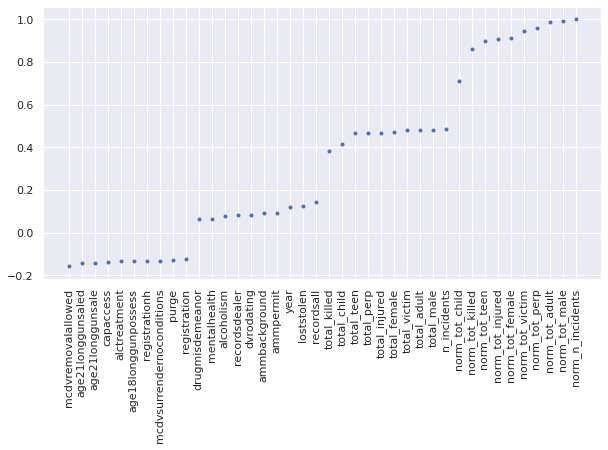

In [289]:
ls_norm = small_large('norm_n_incidents')

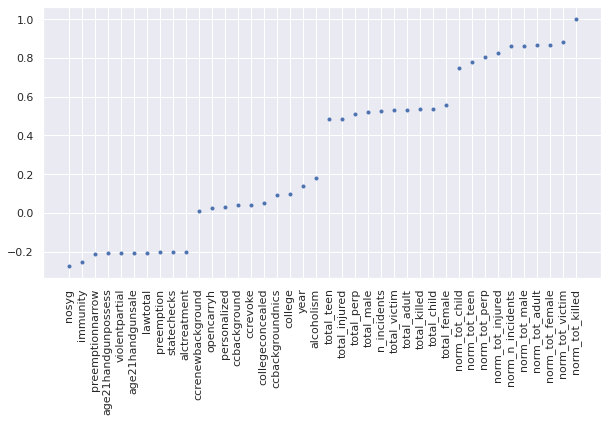

In [290]:
ls_kill = small_large('norm_tot_killed')

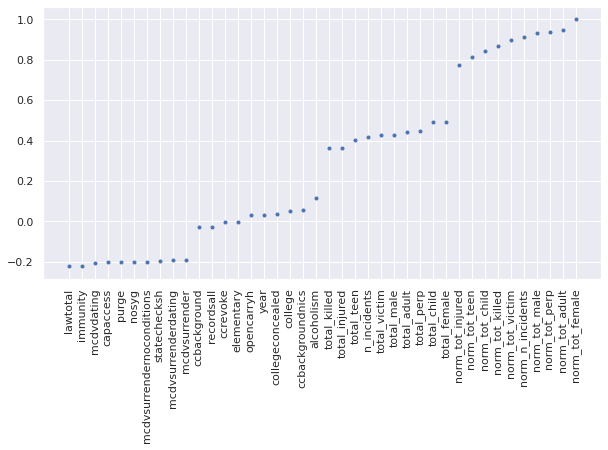

In [291]:
ls_female = small_large('norm_tot_female')

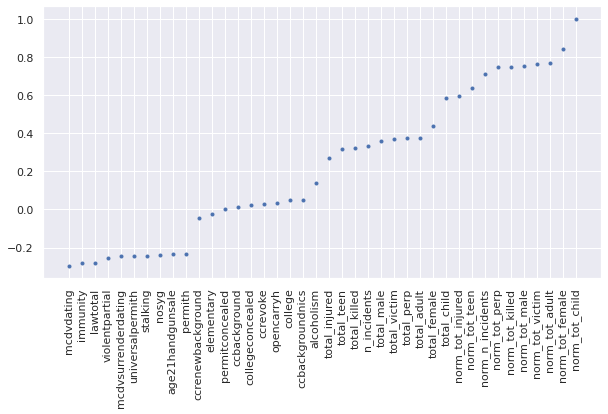

In [292]:
ls_child = small_large('norm_tot_child')

In [288]:
ls_norm

Index(['mcdvdating', 'immunity', 'lawtotal', 'violentpartial',
       'mcdvsurrenderdating', 'universalpermith', 'stalking', 'nosyg',
       'age21handgunsale', 'permith', 'norm_tot_child', 'norm_tot_female',
       'norm_tot_adult', 'norm_tot_victim', 'norm_tot_male', 'norm_tot_killed',
       'norm_tot_perp', 'norm_n_incidents', 'norm_tot_teen',
       'norm_tot_injured', 'total_child', 'total_female', 'total_adult',
       'total_perp', 'total_victim', 'total_male', 'n_incidents',
       'total_killed', 'total_teen', 'total_injured', 'alcoholism',
       'ccbackgroundnics', 'college', 'opencarryh', 'ccrevoke',
       'collegeconcealed', 'ccbackground', 'permitconcealed', 'elementary',
       'ccrenewbackground'],
      dtype='object')

In [293]:
ls_child

Index(['mcdvdating', 'immunity', 'lawtotal', 'violentpartial',
       'mcdvsurrenderdating', 'universalpermith', 'stalking', 'nosyg',
       'age21handgunsale', 'permith', 'norm_tot_child', 'norm_tot_female',
       'norm_tot_adult', 'norm_tot_victim', 'norm_tot_male', 'norm_tot_killed',
       'norm_tot_perp', 'norm_n_incidents', 'norm_tot_teen',
       'norm_tot_injured', 'total_child', 'total_female', 'total_adult',
       'total_perp', 'total_victim', 'total_male', 'n_incidents',
       'total_killed', 'total_teen', 'total_injured', 'alcoholism',
       'ccbackgroundnics', 'college', 'opencarryh', 'ccrevoke',
       'collegeconcealed', 'ccbackground', 'permitconcealed', 'elementary',
       'ccrenewbackground'],
      dtype='object')

In [294]:
ls_female

Index(['lawtotal', 'immunity', 'mcdvdating', 'capaccess', 'purge', 'nosyg',
       'mcdvsurrendernoconditions', 'statechecksh', 'mcdvsurrenderdating',
       'mcdvsurrender', 'norm_tot_female', 'norm_tot_adult', 'norm_tot_perp',
       'norm_tot_male', 'norm_n_incidents', 'norm_tot_victim',
       'norm_tot_killed', 'norm_tot_child', 'norm_tot_teen',
       'norm_tot_injured', 'total_female', 'total_child', 'total_perp',
       'total_adult', 'total_male', 'total_victim', 'n_incidents',
       'total_teen', 'total_injured', 'total_killed', 'alcoholism',
       'ccbackgroundnics', 'college', 'collegeconcealed', 'year', 'opencarryh',
       'elementary', 'ccrevoke', 'recordsall', 'ccbackground'],
      dtype='object')

In [309]:
df_targets = df_pop_corr.iloc[-21:, -21:]

In [310]:
df_targets

,n_incidents,total_killed,total_injured,total_adult,total_teen,total_child,total_male,total_female,total_perp,total_victim,pop,norm_n_incidents,norm_tot_killed,norm_tot_injured,norm_tot_adult,norm_tot_teen,norm_tot_child,norm_tot_male,norm_tot_female,norm_tot_perp,norm_tot_victim
recordsall,0.177392,0.123681,0.225406,0.135496,0.175681,-0.028793,0.160263,0.060791,0.108582,0.173039,0.209530,0.145545,-0.064785,0.218654,0.105276,0.169076,-0.092324,0.134936,-0.026660,0.086199,0.125311
total_killed,0.937646,1.000000,0.857248,0.944756,0.876739,0.831407,0.935339,0.935697,0.928675,0.922285,0.701642,0.384538,0.532971,0.499639,0.389100,0.435881,0.323330,0.410686,0.363005,0.308751,0.485741
total_child,0.793511,0.831407,0.687049,0.852591,0.755617,1.000000,0.826048,0.911795,0.850671,0.822488,0.502571,0.415069,0.534395,0.468976,0.466616,0.468794,0.586407,0.474087,0.489381,0.401529,0.546601
total_teen,0.966371,0.876739,0.962920,0.944673,1.000000,0.755617,0.964756,0.914603,0.917773,0.964468,0.579318,0.465080,0.485290,0.628180,0.450885,0.598339,0.315161,0.495875,0.400375,0.370479,0.570805
total_perp,0.965439,0.928675,0.864371,0.986276,0.917773,0.850671,0.978079,0.972129,1.000000,0.932019,0.637912,0.466853,0.510545,0.544369,0.486254,0.523287,0.376525,0.509339,0.444939,0.433261,0.545946
total_injured,0.959366,0.857248,1.000000,0.916790,0.962920,0.687049,0.946415,0.858290,0.864371,0.967802,0.553492,0.466895,0.486019,0.666981,0.435972,0.555001,0.272019,0.485320,0.363227,0.334804,0.577132
total_female,0.946682,0.935697,0.858290,0.976542,0.914603,0.911795,0.962514,1.000000,0.972129,0.944173,0.610602,0.469351,0.554785,0.559088,0.496688,0.537190,0.439709,0.514555,0.492785,0.426578,0.578770
total_victim,0.983008,0.922285,0.967802,0.974710,0.964468,0.822488,0.984005,0.944173,0.932019,1.000000,0.599961,0.479934,0.527997,0.636790,0.477911,0.556935,0.366937,0.513537,0.425431,0.379096,0.607335
total_adult,0.988033,0.944756,0.916790,1.000000,0.944673,0.852591,0.994765,0.976542,0.986276,0.974710,0.637805,0.480129,0.529641,0.589663,0.493183,0.538356,0.377132,0.518140,0.443654,0.415489,0.580580
total_male,0.995883,0.935339,0.946415,0.994765,0.964756,0.826048,1.000000,0.962514,0.978079,0.984005,0.627157,0.481998,0.519892,0.609433,0.484751,0.550946,0.358388,0.518086,0.429429,0.406707,0.582862


In [320]:
unnorm_arr = df_targets.iloc[1:11,:10].values
np.mean(unnorm_arr)

0.928048317825325

In [322]:
norm_arr = df_targets.iloc[11:,11:].values
np.mean(norm_arr)
# norm_arr

0.8774428262708672

In [306]:
df_pop_corr

,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,violent,violenth,violentpartial,dealer,dealerh,recordsall,recordsallh,recordsdealer,recordsdealerh,reportall,reportallh,reportdealer,reportdealerh,purge,residential,theft,security,inspection,ammlicense,ammrecords,permit,permith,fingerprint,training,permitlaw,registration,registrationh,defactoreg,defactoregh,ammpermit,ammrestrict,age21handgunsale,age18longgunsale,age21longgunsaled,age21longgunsale,age21handgunpossess,age18longgunpossess,age21longgunpossess,loststolen,amm18,amm21h,universal,universalh,gunshow,gunshowh,universalpermit,universalpermith,backgroundpurge,ammbackground,threedaylimit,mentalhealth,statechecks,statechecksh,waiting,waitingh,assault,onefeature,assaultlist,assaultregister,assaulttransfer,magazine,tenroundlimit,magazinepreowned,onepermonth,traffickingbackground,traffickingprohibited,traffickingprohibitedh,strawpurchase,strawpurchaseh,microstamp,gvro,gvrolawenforcement,college,collegeconcealed,elementary,opencarryh,opencarryl,opencarrypermith,opencarrypermitl,permitconcealed,mayissue,showing,ccbackground,ccbackgroundnics,ccrenewbackground,ccrevoke,nosyg,personalized,lockd,lockp,locked,lockstandards,capliability,capaccess,capuses,capunloaded,cap18,cap16,cap14,junkgun,liability,immunity,preemption,preemptionnarrow,preemptionbroad,mcdv,mcdvdating,mcdvsurrender,mcdvsurrendernoconditions,mcdvsurrenderdating,mcdvremovalallowed,mcdvremovalrequired,incidentremoval,incidentall,dvro,dvrodating,exparte,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal,n_incidents,total_killed,total_injured,total_adult,total_teen,total_child,total_male,total_female,total_perp,total_victim,pop,norm_n_incidents,norm_tot_killed,norm_tot_injured,norm_tot_adult,norm_tot_teen,norm_tot_child,norm_tot_male,norm_tot_female,norm_tot_perp,norm_tot_victim
mcdvremovalallowed,5.208828e-02,0.091731,0.230492,0.239986,0.246513,0.253908,0.360299,-0.097532,0.152194,0.226000,0.226000,0.203024,0.447270,0.261699,-0.092966,0.071113,-0.139439,0.016555,0.198850,0.327579,0.131736,0.295683,0.340471,-0.037147,-0.053078,0.140771,-0.053078,0.347960,-0.037147,0.225042,0.254523,0.163152,0.156668,0.273800,0.549387,0.280070,0.291429,0.346045,-0.065695,0.126204,0.077276,0.009392,0.466650,0.466650,0.185162,0.302503,-0.037147,-0.042843,-0.104915,-0.038824,0.073169,0.072655,0.051047,0.053009,0.270458,0.175634,0.218013,-0.065695,0.257807,0.058970,0.318951,0.205454,0.218700,0.355960,-0.011792,-0.065695,-0.011792,0.024214,-0.076679,-0.028251,-0.043312,0.072239,0.049560,-0.053078,-0.025593,-0.045543,-0.053078,-0.076679,-0.043040,0.180439,0.070149,-0.139525,-0.090133,-0.003255,-0.071340,0.187039,0.162971,0.341265,0.113486,0.163152,0.210619,0.130015,0.316270,0.168880,0.037845,0.251502,0.086602,-0.061586,0.024214,-0.037147,-0.065695,0.175554,0.407828,0.203024,0.280070,0.141420,0.251479,0.203024,0.367244,-0.053078,0.188945,0.278278,0.210619,0.185162,0.251502,0.376171,0.273800,0.318951,0.383127,1.000000,0.500669,0.110234,0.158364,0.261769,0.205454,0.292693,0.100922,0.384940,0.239730,0.284171,0.350700,0.143653,0.143653,0.325716,0.123865,0.288375,-0.103073,-0.107477,-0.104740,-0.099519,-0.076291,-0.110236,-0.098995,-0.099598,-0.088229,-0.109223,-0.047107,-0.158196,-0.156612,-0.149064,-0.148166,-0.105010,-0.145337,-0.149733,-0.144208,-0.139457,-0.152137
age21longgunsaled,6.057455e-02,0.050943,0.105037,0.157471,0.074038,0.233318,0.315452,-0.062084,0.315452,0.408780,0.408780,0.152578,0.290985,0.171417,-0.059177,-0.095564,-0.039081,-0.047510,0.373643,0.236277,0.290985,0.193268,0.222104,-0.023646,-0.033787,-0.074023,-0.033787,-0.035228,-0.023646,0.305150,0.186947,0.245576,0.320894,0.199907,0.863075,0.480909,0.496363,0.248826,-0.041818,0.261720,0.261103,0.201320,1.000000,1.000000,0.266383,0.246102,-0.023646,-0.074023,-0.066783,-0.072239,-0.015802,-0.032215,-0.026196,-0.

In [344]:
X = df_merge_pop.iloc[:, 2:-21].values
y = df_merge_pop['norm_n_incidents'].values

In [347]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = LinearRegression().fit(X_train, y_train)
y_pred = clf.predict(X_train)
clf.score(X_train, y_train)

0.5430211086125899

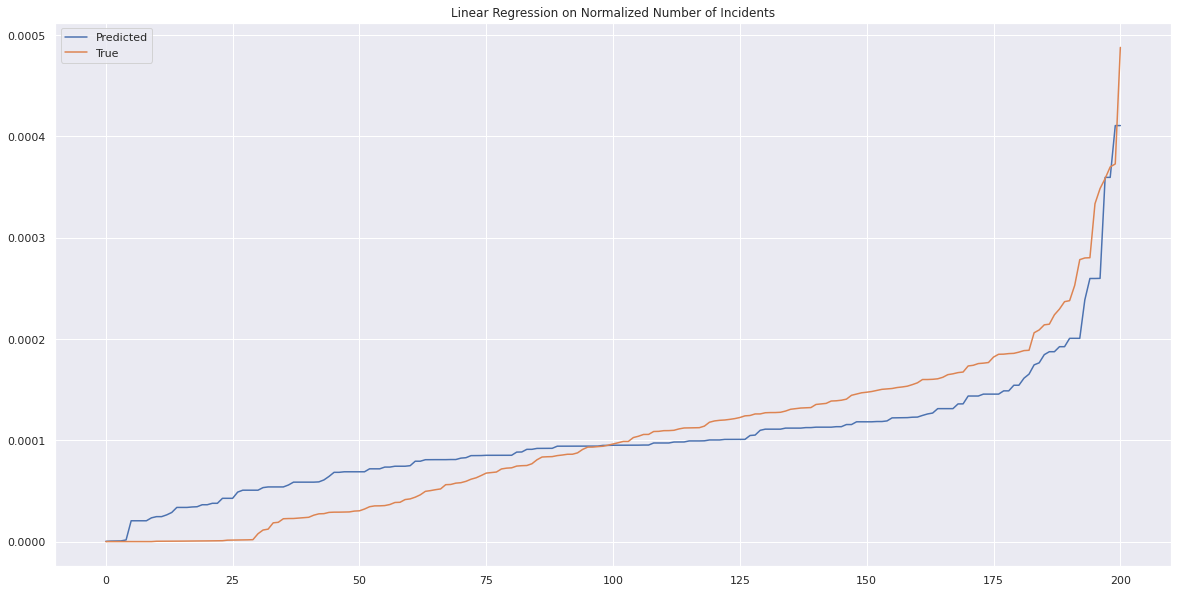

In [367]:
plt.figure(figsize=(20,10))
plt.plot(np.sort(y_pred), label = 'Predicted')
plt.plot(np.sort(y_train), label = 'True')
plt.title('Linear Regression on Normalized Number of Incidents')
plt.legend()

In [355]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

X = df_merge_pop.iloc[:, 2:-22].values
X = np.transpose(X)
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(X)
# X

KMeans(init='random', n_clusters=3, random_state=42)

In [356]:
kmeans.inertia_

3571.3967611336043

ValueError: x and y must be the same size

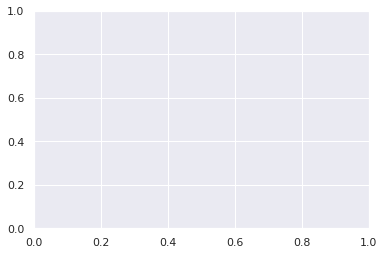

In [360]:
plt.scatter(range(len(X)), X)